#### Adaptive Implementation design

1. Solving classical system
2. Finding values of optimal $C^s$

### Solve a classical system of differential equations
Here we just program a function that solves the classic ODE system:

$$
\begin{align*}
    &\frac{dS}{dt}= -C(\cdot)\beta SI/N\\
    &\frac{dI}{dt}= C(\cdot)\beta SI/N -\nu I \\
    &\frac{dZ}{dt}=\nu I.
\end{align*}
$$

Depending on the value of the constant $C(\cdot) \in \mathbb{R}_{>0}$.

In [57]:
from scipy.integrate import odeint
from scipy.optimize import fmin
import numpy as np
import time
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d ### Might be useful

### Utils

def plot_ode_solution(S,I,Z,t,model):
    plt.plot(t,S,label="Susceptible")
    plt.plot(t,I,label="Infected")
    plt.plot(t,Z,label="Recovered (Immune)")
    plt.title(f"Plot of S-I-Z functions ({model})")
    plt.xlabel("Time (t)")
    plt.ylabel("Number of individuals")
    plt.legend(loc="upper right")
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()

##### Solve classical SIR model with constant C(.) and parameters

In [14]:
def odes_simple(x, t, c, beta, nu, N):

    # assign each function to a vector element
    S = x[0]
    I = x[1]
    Z = x[2]

    # classical system depending on c, beta, nu and N
    dSdt = -(beta/N)*c*S*I 
    dIdt = (beta/N)*c*S*I - nu*I 
    dZdt = nu*I 

    return [dSdt, dIdt, dZdt]

In [15]:
def solve_classical_SIR(x0,c,beta,nu,t_max,h):
    
    """
    Solve the classical system with initial conditions
    x_0 = [S_0,I_0,Z_0]
    c,beta,nu parameters of the classical ODE's system.
    Solve for t in [0,t_max]
    Create linspace with points seperated by an uniform distance of h
    """
    S0,I0,Z0= x0[0],x0[1],x0[2]
    N=sum(x0)
    
    t = np.linspace(0,t_max,int(t_max/h))
    x = odeint(odes_simple, x0, t, args=(c,beta,nu,N))

    S = x[:,0]
    I = x[:,1]
    Z = x[:,2]
    
    return S,I,Z

#### Example

We solve a classical SIR model with non adaptive contact rate.

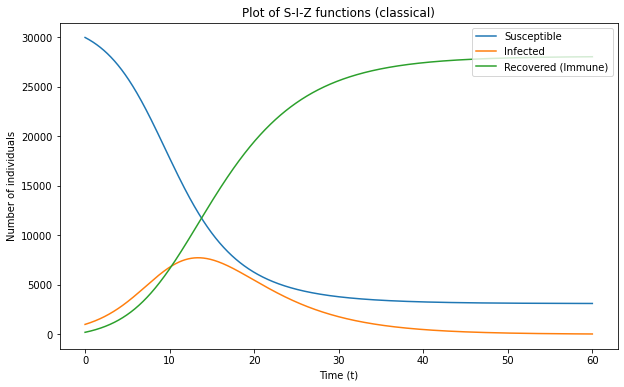

In [74]:
### Initial Conditions
S0 = 30000
I0 = 1000
Z0 = 200
x0 = [S0, I0, Z0]

### Model parameters
c=5
beta=0.0925
nu=0.1823

### Solution x-axis steps
t_max=60
h=60/1000
t = np.linspace(0,t_max,int(t_max/h))

### Solve
S_classic,I_classic,Z_classic = solve_classical_SIR(x0,c,beta,nu,t_max,h)

### Plot
plot_ode_solution(S_classic,I_classic,Z_classic,t,"classical")

#### Adaptive approach

The constant $C(\cdot)$ changes through time using a planning window.

The formula for $C(\cdot)$ is given by

$$
C(\cdot)(t) = C^{si}(t) = \frac{N \cdot C^s(t) \cdot C^i(t)}{S(t)\cdot C^s(t) + I(t)\cdot C^i(t) + Z(t) \cdot C^z(t)},
$$

where

- $C^h(t)$ is the optimal number of average contacts made by individuals of type $h \in Y=\{s,i,z\}$ at time $t$.
- $S(t),I(t),Z(t)$ are the number of susceptible, infected and recovered individuals at time $t$.
- $N$ is the entirety of the population.

Thus, in order to find $C(\cdot)(t)$ we need to find the values of the functions of optimal average contacts $C^h(t)$ for $h \in Y$.

For individuals of types $i$ and $z$ the optimal number of average contacts are given by $C^h(t)= 0.5b^h$ where $b^h$ is a given constant. For indiviuals of type $s$ the adaptive algorithm enters the play.

So for each time there is an optimal $C_t^{s*}$ that has to be introduced into the model to solve it. We program the next function that solves the classical SIR model using a $C_t^{s*}$ imput (as a vector)

In [59]:
### Solves the ODE system in an interval 
### We need to implement the computation of C_t^{s*}

def get_Cs_opt(S,I,Z,bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t):
    
    """
    Select the optimal C_t^s in the interval [0, 0.5b^s] for which we attain the maximum of the 
    value function. For now I'm using the direct implementation from equation (2.2) in the notes.
    We might need to review this and instead use the backwards induction technique (not clear how!).
    
    Attributes:
    - values of S_t,I_t,Z_t at time t.
    - adaptive utility parameters b^z,b^i,b^s,gamma.
    - time window planning info: tau, delta.
    - SIR model parameters: beta, nu.
    - time: t
    """
    
    phi_t = S*0.5*bs + I*0.5*bi + Z*0.5*bz  ### Questions
    
    Pz = 1 - math.exp(-1*nu)  ### Probability of recovery.
    xi = ( (1 - delta**(tau+1) )/(1 - delta) ) - ( (1 - ( delta*(1-Pz) )**(tau+1)  )/( 1 - delta*(1-Pz) ) ) ### Xi function in notes
    vti = ((0.25* (bz)**2 )**gamma - az)*xi ### Value of V_{t+1}(i) for t inside interval [t_0,t_0+tau-1)
     
    ### Probability that an s-type individual becomes infected at time t.
    ### Depends on selection of C_s^t
    
    def P_it(C_st):
        P_it = 1 - math.exp(-1*(0.5*beta*bi*I*C_st)/phi_t)
        return P_it
    
    """
    Now we employ the backwards induction method to compute C_t^s.
    - The idea is that the individual will become infected at time tau.
    - We start with time t+tau and move backwards to time t
    """
    
    def vs1(C_st, vti):
        expr0 = 0.5*beta*bi*I*math.exp(-1*(0.5*beta*bi*I*C_st)/phi_t)
        expr1 = (gamma*(bs*C_st - C_st**2)**(gamma-1) + bs -2*C_st) / expr0
        expr2 = (1 - P_it(C_st))*expr1 + vti
        return (bs*C_st - C_st**2)**gamma - as1 - delta*expr2
    
    C_st_array = np.linspace(0,0.5*bs,1000)
    C_st_args = [0]*(tau+1)
    Vs1s=[0]*(tau+1) ### length is tau+1 [goes from 0 to tau]
    Vi1s=[vti]*(tau - 1) + [(0.25* (bi)**2 )**gamma - ai] + [0]  ###length is tau+1
    
    ### t+tau
    C_st_tau_step = [vs1(C_st, vti = Vi1s[tau] ) for C_st in C_st_array]
    Vs1s[tau] = max(C_st_tau_step) ### This is V_{t_0+tau + 1}
    C_st_args[tau] = C_st_array[np.argmax(C_st_tau_step)]
    
    ### Go over all the other steps (backwards):
    for j in range(1,tau+1):
        
        ### Get V_{t_0 + tau - j + 1}(i)
        v_i_tau_j_1=Vi1s[tau-j+1]
        ### Get V_{t_0 + tau - j + 1}(s)
        v_s_tau_j_1=Vs1s[tau-j+1]
        
        ### Use formula (6) of article to find V_{t_0+ tau -j}
        val_func_values = [ (bs*C_st - C_st**2)**gamma - as1 + delta*((1 - P_it(C_st))*v_s_tau_j_1 + P_it(C_st)*v_i_tau_j_1) for C_st in C_st_array]
        Vs1s[tau-j] = max(val_func_values)
        C_st_args[tau-j] = C_st_array[np.argmax(val_func_values)]
    
    Cs_opt=C_st_args[0]
    
    return Cs_opt

In [60]:
def odes_adaptive(x, t, bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,N):

    # assign each function to a vector element
    S = x[0]
    I = x[1]
    Z = x[2]
    
    Cs_opt = get_Cs_opt(S,I,Z,bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t)
    #Cs_opt= 0.5*bs
    
    # adaptive system depending on beta, nu and N
    dSdt = -(beta/N)*(Cs_opt*0.5*bi*N/(S*Cs_opt + I*0.5*bi+Z*0.5*bz) )*S*I 
    dIdt = (beta/N)*(Cs_opt*0.5*bi*N/(S*Cs_opt + I*0.5*bi+Z*0.5*bz) )*S*I - nu*I 
    dZdt = nu*I 

    return [dSdt, dIdt, dZdt]

In [61]:
def solve_adaptive_SIR(x0, bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu, t_max,h):
    
    """
    Solve the classical system with initial conditions
    x_0 = [S_0,I_0,Z_0]
    c,beta,nu parameters of the classical ODE's system.
    Solve for t in [0,t_max]
    Create linspace with points seperated by an uniform distance of h
    """
    
    S0,I0,Z0= x0[0],x0[1],x0[2]
    N=sum(x0)
    
    t = np.linspace(0,t_max,int(t_max/h))
    x = odeint(odes_adaptive, x0, t, args=(bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,N))

    S = x[:,0]
    I = x[:,1]
    Z = x[:,2]
    
    return S,I,Z

Experiments

In [ ]:
### Initial Conditions
S0 = 30000
I0 = 1000
Z0 = 200
x0 = [S0, I0, Z0]

### Model parameters
beta=0.0925
nu=0.1823

### Adaptive parameters
bi=6.67
bz=10
bs=bz

ai=1.826
az=0 ### By default
as1=0 ### By default
gamma=0.25
tau=12
delta=0.99986

### Solution x-axis steps
t_max=60
h=60/1000
t = np.linspace(0,t_max,int(t_max/h))

### Solve
start=time.time()
S_adaptive,I_adaptive,Z_adaptive = solve_adaptive_SIR(x0, bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu, t_max,h)
end=time.time()

print(f"Adaptive solution took: {(end - start)/60} minutes")

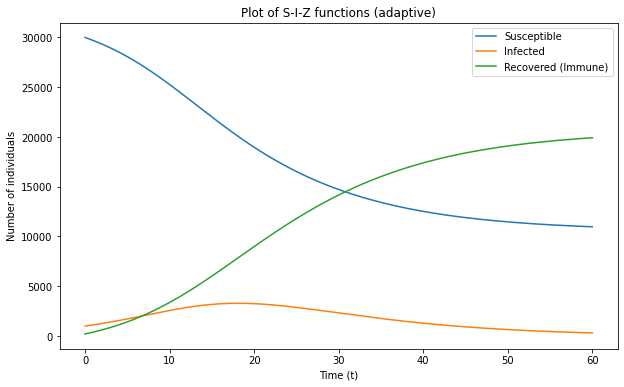

In [77]:
### Plot
plot_ode_solution(S_adaptive,I_adaptive,Z_adaptive,t,"adaptive")

### Review and Comparison

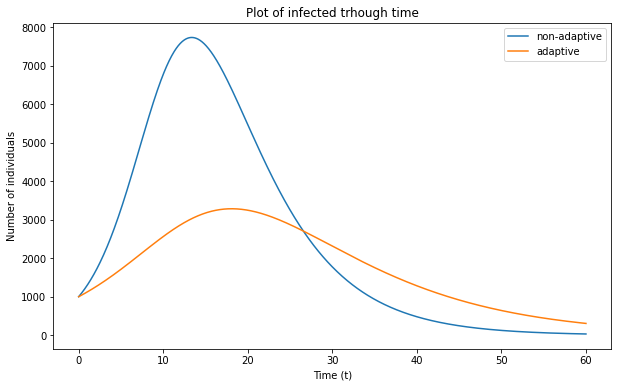

In [78]:
plt.plot(t,I_classic,label="non-adaptive")
plt.plot(t,I_adaptive,label="adaptive")
plt.title(f"Plot of infected trhough time")
plt.xlabel("Time (t)")
plt.ylabel("Number of individuals")
plt.legend(loc="upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

### Discussion

Discuss results and review